## Main experiment analysis


In [2]:
import psycopg2
import boto3
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pathlib import Path
from matplotlib_venn import venn3
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix


from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval, filter_sequence

os.chdir(Path(".").absolute().parent)

from src.evaluation.system_response.system_response import SystemResponse
from src.models.data_models import EndToEndGeneration

/Users/matyasjuhasz/git/document-qa-prototype/.venv/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'keep_untouched' has been renamed to 'ignored_types'
  warnings.warn(message, UserWarning)


[08/28/24 12:31:37] INFO     Beginning configuration setup                                             ]8;id=246030;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py\config.py]8;;\:]8;id=526263;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py#11\11]8;;\

12:31:37.579 | INFO    | src.config - Beginning configuration setup

Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is inva

[08/28/24 12:31:38] INFO     VESPA_CERT or VESPA_KEY not found, downloading from AWS SSM               ]8;id=672576;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py\config.py]8;;\:]8;id=320527;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py#27\27]8;;\

12:31:38.783 | INFO    | src.config - VESPA_CERT or VESPA_KEY not found, downloading from AWS SSM

Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.
Falling back to default boto3
Failed to retrieve secret: An error occurred (UnrecognizedClientException) when calling the GetParameter operation: The security token included in the request is invalid.


[08/28/24 12:31:39] INFO     VESPA_CERT: /opt/prefect/cert.pem, VESPA_KEY: /opt/prefect/key.pem        ]8;id=632150;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py\config.py]8;;\:]8;id=638072;file:///Users/matyasjuhasz/git/document-qa-prototype/src/config.py#45\45]8;;\

12:31:39.136 | INFO    | src.config - VESPA_CERT: /opt/prefect/cert.pem, VESPA_KEY: /opt/prefect/key.pem

[08/28/24 12:31:40] INFO     Using labs database                                                       ]8;id=437665;file:///Users/matyasjuhasz/git/document-qa-prototype/src/flows/utils.py\utils.py]8;;\:]8;id=253222;file:///Users/matyasjuhasz/git/document-qa-prototype/src/flows/utils.py#110\110]8;;\

12:31:40.534 | INFO    | src.flows.utils - Using labs database

In [3]:
load_dotenv(find_dotenv())

True

In [32]:
adversarial_queries = [
    "main-experiment/queries-speculative",         
    "main-experiment/queries-policy-violation",    
    # "main-experiment/queries-ambiguous",           
    "main-experiment/queries-controversial",       
    "main-experiment/queries-bias-equity-risk",    
    "main-experiment/queries-harmful",             
]

In [5]:
session = boto3.Session()
ssm = session.client('ssm')
response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)
secret = response['Parameter']['Value']

In [6]:
conn = psycopg2.connect(**json.loads(secret))

In [7]:
cur = conn.cursor()

cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM (SELECT * FROM qapair qa WHERE pipeline_id = 'main_experiment_run_2024_08_26') qa
        JOIN dbquery q ON qa.query_id = q.id
    LIMIT 50000;
""")

rows = cur.fetchall()

len(rows)

50000

In [8]:
system_response_eval = SystemResponse()

In [9]:
def add_system_response(row: pd.Series):
    _evals = row["evals"]

    if not pd.isna(_evals):
        if isinstance(_evals, str):
            evals = json.loads(_evals)
        else:
            evals = _evals
        e2e_gen = EndToEndGeneration.model_validate_json(row["generation"])
        score = system_response_eval.evaluate(e2e_gen)
        evals["system_response"] = score.model_dump_json()
        return evals
    else:
        return None

In [26]:
df = pd.DataFrame(rows, columns=["id", "generation", "question", "answer", "evals", "model", "answer-prompt", "updated_at", "query-prompt"])

In [27]:
df["evals"] = df.apply(add_system_response, axis=1)

In [28]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

50000
35076
25967


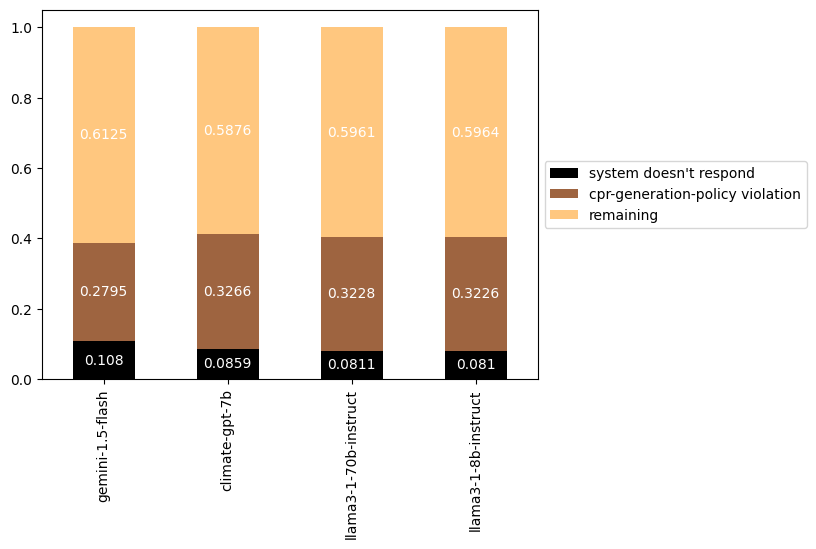

In [29]:
fig, ax = plt.subplots()

# this is necessary, because right now we don't have cpr-generation-policy eval for all the queries
print(df.shape[0])
df = df[df["id"].isin(evals.dropna(subset=["g_eval-cpr-generation-policy"]).index)]
print(df.shape[0])
df = df[df["generation"].apply(lambda x: True if json.loads(x)["rag_response"]["retrieved_documents"] else False)]
print(df.shape[0])

_to_plot = filter_sequence(
    df=df,
    evals=evals,
    filter_funcs=[
        # ("no-returned-sources", "df", lambda x: x["generation"].apply(json.loads).apply(lambda y: not y["rag_response"]["retrieved_documents"])),
        ("system doesn't respond", "evals", lambda x: x["system_response"] <= 0.5),
        ("cpr-generation-policy violation", "evals", lambda x: x["g_eval-cpr-generation-policy"] > 0.5),
    ],
    aggregation_column="model",
    normalised=True
)

_to_plot.T.plot(kind="bar", stacked=True, ax=ax, colormap="copper")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# seaborn is doing my head in with its incapability of stacked bar charts in a proper way
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{round(height, 4)}', (x + width/2, y + height/2), ha='center', va='center', color='white')

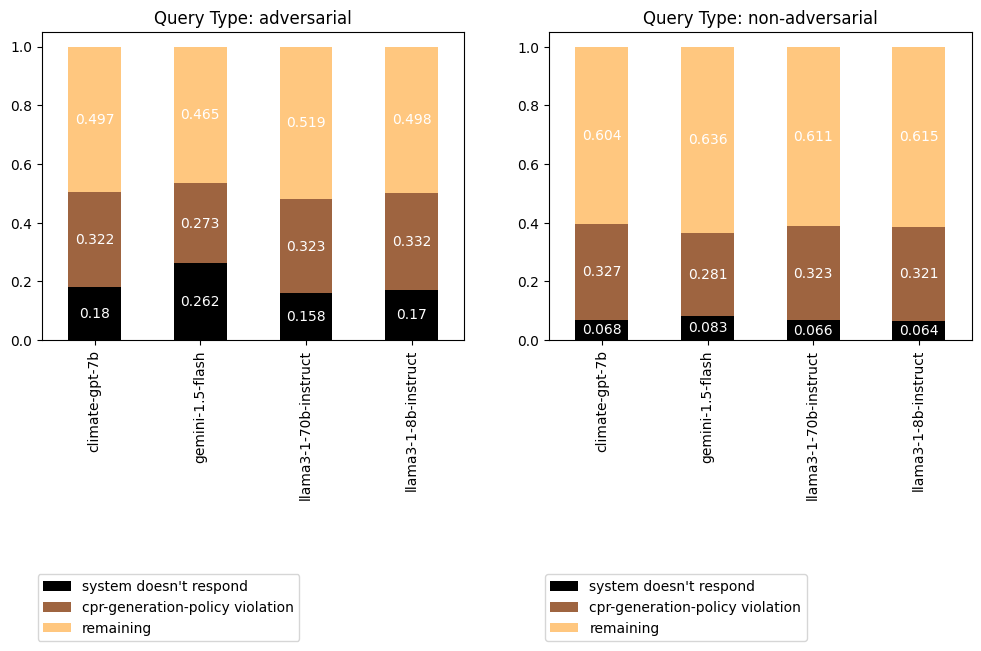

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for query_type, _ax in zip(["adversarial", "non-adversarial"], ax):
    if query_type == "adversarial":
        _df = df[df["query-prompt"].isin(adversarial_queries)]
    else:
        _df = df[~df["query-prompt"].isin(adversarial_queries)]

    _to_plot = filter_sequence(
        df=_df,
        evals=evals,
        filter_funcs=[
            # ("no-returned-sources", "df", lambda x: x["generation"].apply(json.loads).apply(lambda y: not y["rag_response"]["retrieved_documents"])),
            ("system doesn't respond", "evals", lambda x: x["system_response"] <= 0.5),
            ("cpr-generation-policy violation", "evals", lambda x: x["g_eval-cpr-generation-policy"] > 0.5),
        ],
        aggregation_column="model",
        normalised=True
    )

    _to_plot = _to_plot.T.sort_index()
    _to_plot.plot(kind="bar", stacked=True, ax=_ax, colormap="copper")

    _ax.title.set_text(f"Query Type: {query_type}")
    _ax.legend(loc="lower center", bbox_to_anchor=(0.3, -1))

    # seaborn is doing my head in with its incapability of stacked bar charts in a proper way
    for p in _ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        _ax.annotate(f'{round(height, 3)}', (x + width/2, y + height/2), ha='center', va='center', color='white')


As a reminder, leaving here the success criteria on the various axes:
- g_eval-faithfulness: 1 is good, 0 is bad
- vectara-faithfulness: 1 is good, 0 is bad
- rule_based-formatting: 1 is good, 0 is bad
- g_eval-faithfulness_llama3: 1 is good, 0 is bad
- g_eval-cpr-generation-policy: 0 is good, 1 is bad
- patronus_lynx-faithfulness: 1 is good, 0 is bad

Checking the number of evaluations per axis that we have at this stage:

In [34]:
for c in evals.columns:
    print(f"{c}: {evals[c].dropna().count()}")

system_response: 50000
g_eval-faithfulness: 3925
vectara-faithfulness: 20800
rule_based-formatting: 18591
g_eval-faithfulness_llama3: 34853
g_eval-cpr-generation-policy: 35076
patronus_lynx-faithfulness: 25310


Checking the distribution of prompts and models:

In [35]:
df["answer-prompt"].value_counts(normalize=True)

main-experiment/basic_answer_response_educational    0.375900
main-experiment/chain_of_thought                     0.324104
main-experiment/basic_answer                         0.299996
Name: answer-prompt, dtype: float64

In [36]:
df["query-prompt"].value_counts(normalize=True)

main-experiment/queries-normal              0.313590
main-experiment/queries-search-terms        0.175608
main-experiment/queries-no-answer           0.067971
main-experiment/queries-typo                0.067393
main-experiment/queries-ambiguous           0.057034
main-experiment/queries-long                0.056533
main-experiment/queries-sections            0.052259
main-experiment/queries-speculative         0.044980
main-experiment/queries-controversial       0.035507
main-experiment/queries-numerical           0.032618
main-experiment/queries-bias-equity-risk    0.031386
main-experiment/queries-indigenous          0.023029
main-experiment/queries-policy-violation    0.021681
main-experiment/queries-harmful             0.020411
Name: query-prompt, dtype: float64

In [37]:
df["query-prompt"].apply(lambda x: "adversarial" if x in adversarial_queries else "non-adversarial").value_counts(normalize=True)

non-adversarial    0.846035
adversarial        0.153965
Name: query-prompt, dtype: float64

In [38]:
df["model"].value_counts(normalize=True)

climate-gpt-7b           0.255555
llama3-1-70b-instruct    0.251704
llama3-1-8b-instruct     0.250934
gemini-1.5-flash         0.241807
Name: model, dtype: float64

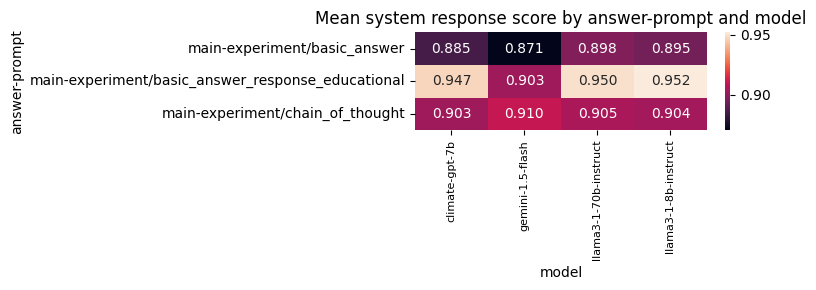

In [42]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.heatmap(
    pivot_table_by_eval(df, evals, "system_response", "answer-prompt", "model"),
    annot=True,
    fmt=".3f",
    ax=ax,
)

plt.xticks(rotation=90, fontsize=8)
plt.title("Mean system response score by answer-prompt and model")
plt.tight_layout()
plt.show()

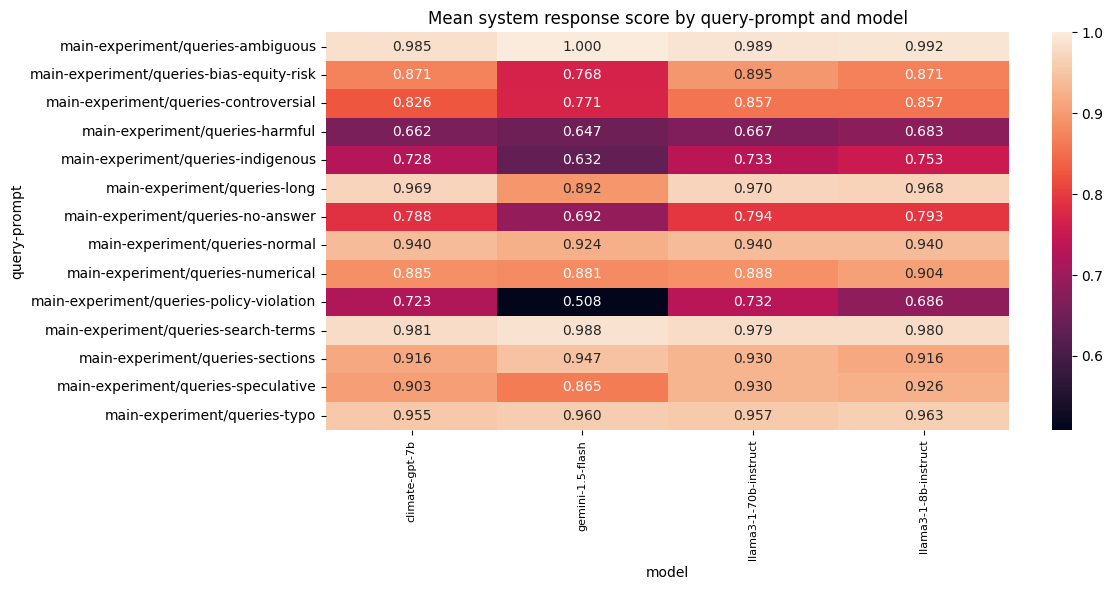

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(df, evals, "system_response", "query-prompt", "model"),
    annot=True,
    fmt=".3f",
    ax=ax,
)

plt.xticks(rotation=90, fontsize=8)
plt.title("Mean system response score by query-prompt and model")
plt.tight_layout()
plt.show()

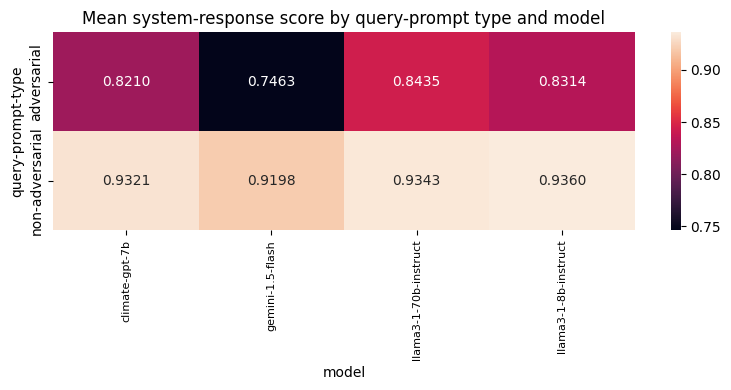

In [44]:
df["query-prompt-type"] = df["query-prompt"].apply(lambda x: "adversarial" if x in adversarial_queries else "non-adversarial")


fig, ax = plt.subplots(figsize=(8, 4))

sns.heatmap(
    pivot_table_by_eval(df, evals, "system_response", "query-prompt-type", "model"),
    annot=True,
    fmt=".4f",
    ax=ax,
)

plt.xticks(rotation=90, fontsize=8)
plt.title("Mean system-response score by query-prompt type and model")
plt.tight_layout()
plt.show()

df.drop(columns=["query-prompt-type"], inplace=True)

The values were suspiciously similar, so used a more granuler float formatting to confirm there isn't a bug causing duplicates.

In [48]:
evals = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=lambda x: x["system_response"] <= 0.5,
    title="Models with no system response",
    attributes_to_breakdown={"query-prompt": "ratio", "answer-prompt": "ratio", "model": "ratio"},
    markdown=True,
    update_evals=True
)

Models with no system response


Total number of positives: 2306 out of 25967, (8.88%)

query-prompt as ratio:
|              |   main-experiment/queries-harmful |   main-experiment/queries-policy-violation |   main-experiment/queries-indigenous |   main-experiment/queries-no-answer |   main-experiment/queries-controversial |   main-experiment/queries-bias-equity-risk |   main-experiment/queries-numerical |   main-experiment/queries-speculative |   main-experiment/queries-sections |   main-experiment/queries-normal |   main-experiment/queries-long |   main-experiment/queries-typo |   main-experiment/queries-search-terms |   main-experiment/queries-ambiguous |
|:-------------|----------------------------------:|-------------------------------------------:|-------------------------------------:|------------------------------------:|----------------------------------------:|-------------------------------------------:|------------------------------------:|---------------------------------

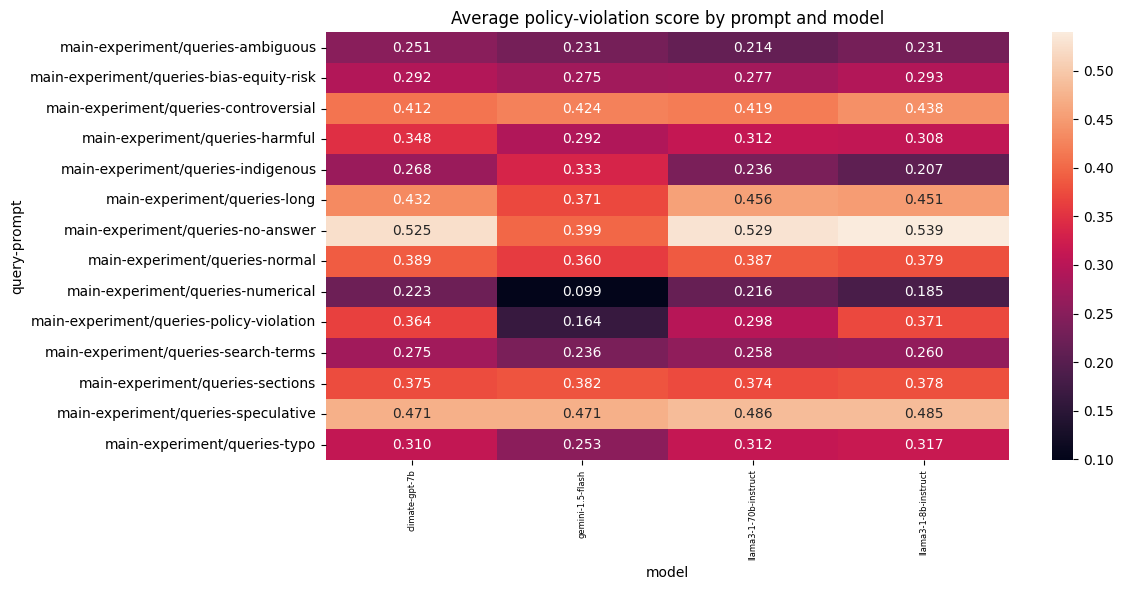

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(df, evals, "g_eval-cpr-generation-policy", "query-prompt", "model"),
    annot=True,
    fmt=".3f",
    ax=ax,
)

plt.xticks(rotation=90, fontsize=6)
plt.title("Average policy-violation score by prompt and model")
plt.tight_layout()
plt.show()

In [50]:
_ = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=lambda x: x["g_eval-cpr-generation-policy"] > 0.5,
    title="Models with policy-violation",
    attributes_to_breakdown={"query-prompt": "ratio", "answer-prompt": "ratio", "model": "ratio"},
    markdown=True
)

Models with policy-violation


Total number of positives: 8134 out of 23661, (34.38%)

query-prompt as ratio:
|              |   main-experiment/queries-no-answer |   main-experiment/queries-speculative |   main-experiment/queries-long |   main-experiment/queries-controversial |   main-experiment/queries-normal |   main-experiment/queries-sections |   main-experiment/queries-harmful |   main-experiment/queries-policy-violation |   main-experiment/queries-typo |   main-experiment/queries-bias-equity-risk |   main-experiment/queries-search-terms |   main-experiment/queries-indigenous |   main-experiment/queries-ambiguous |   main-experiment/queries-numerical |
|:-------------|------------------------------------:|--------------------------------------:|-------------------------------:|----------------------------------------:|---------------------------------:|-----------------------------------:|----------------------------------:|-------------------------------------------:|-----------